<a href="https://colab.research.google.com/github/plotnikova-ancka/NN/blob/master/4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Занятие 4 - Сверточные нейронные сети (Сonvolutional neural network, CNN)

## Импорт необходимых библиотек

In [1]:
from PIL import Image, ImageFilter
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization
from tensorflow.keras.datasets import mnist

Импорт библиотеки для рисования графиков и изображений

In [3]:
%matplotlib inline
import seaborn as sns

Импорт вспомогательных библиотек

In [4]:
from sklearn.metrics import confusion_matrix
import itertools

## Включение вычислений на GPU

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Демонстрация воздействия операции свёртки на изображение

Загрузим изображение и посмотрим как раличные свёртки на него воздествуют

In [6]:
response = requests.get("https://www.culture.ru/s/vopros/kremlin/images/tild3264-3233-4131-b836-623939356634__noroot.png")
img = Image.open(BytesIO(response.content))
# img = Image.open("image.jpg") # For local image
img.load()
img=img.resize((1258,1258))
img_color = img.convert("RGB")
data_color = np.asarray(img_color, dtype="int32")
img_gray = img.convert("LA")
data = np.asarray(img_gray, dtype="int32")
data = data.astype("float32")[:,:,0]/255
img.close()

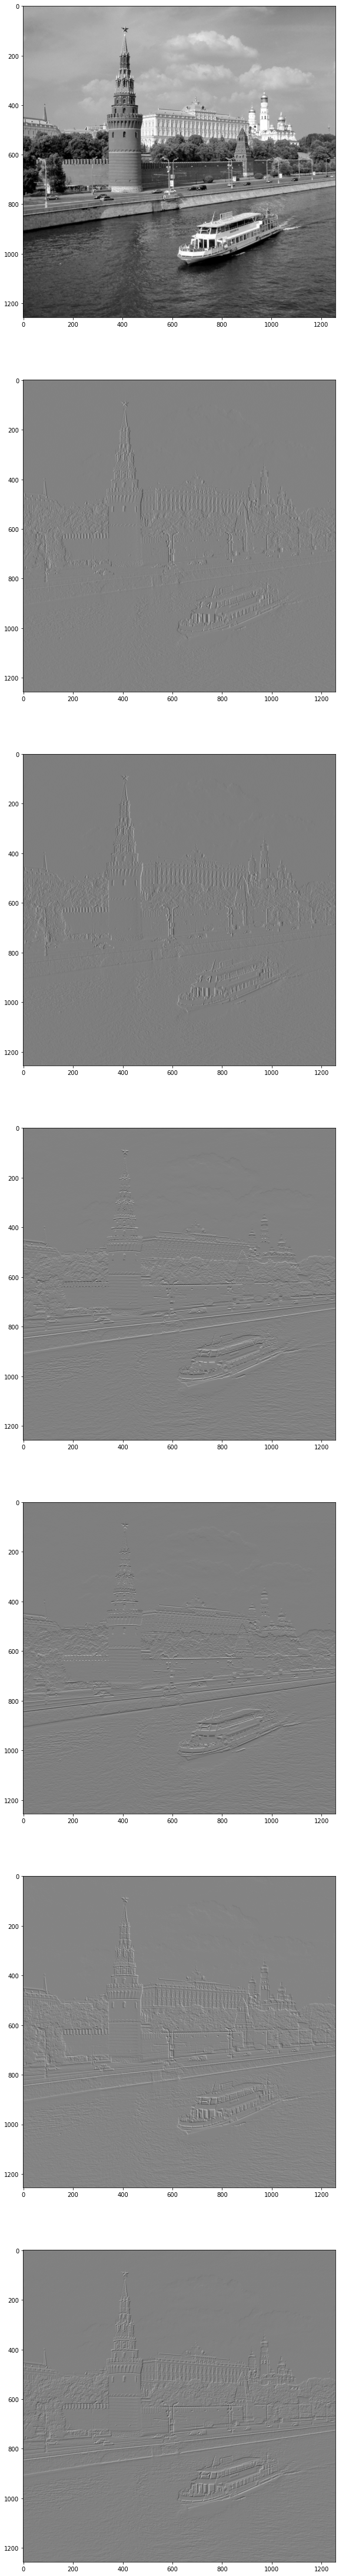

In [ ]:
conv_kernels = list()
conv_kernels.append(np.array([[-1,0,1], [-1,0,1], [-1,0,1]]))
conv_kernels.append(np.array([[1,0,-1], [1,0,-1], [1,0,-1]]))

conv_kernels.append(np.array([[-1,-1,-1], [0,0,0], [1,1,1]]))
conv_kernels.append(np.array([[1,1,1], [0,0,0], [-1,-1,-1]]))

conv_kernels.append(np.array([[0,-1,-1], [1,0,-1], [1,1,0]]))
conv_kernels.append(np.array([[-1,-1,0], [-1,0,1], [0,1,1]]))

fig = plt.figure(figsize=(30,80))
fig.add_subplot(len(conv_kernels) + 1, 1, 1)
plt.imshow(data, cmap='gray')
for i in range(len(conv_kernels)):
    cdata = signal.convolve2d(data, conv_kernels[i], 'valid')
    fig.add_subplot(len(conv_kernels) + 1, 1, i+2)
    plt.imshow(cdata, cmap='gray')
plt.show()

Перевод данных в таблицу тренировочных изображений, их классов (какая это цифра), а также тестовой выборки

## Создание свёрточной модели нейронной сети


Загрузка всем mnist и его нормировка

In [7]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# Reshape the images.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
input_shape = x_train[0].shape

11493376/11490434 [==============================] - 0s 0us/step


Определение свёрточной модели

In [8]:
model = Sequential([
  Conv2D(32,kernel_size=(3,3), input_shape=input_shape, activation ='relu', padding='same'),
	Conv2D(32,kernel_size=(3,3), activation ='relu', padding='same'),
	MaxPool2D(pool_size=(2, 2)),
	

	Conv2D(64,kernel_size=(3,3), activation ='relu', padding = 'same'),
	Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'),
  MaxPool2D(pool_size=(2, 2)),
    
	Flatten(),
  Dense(128, activation=tf.nn.relu),
  Dropout(0.25),
  Dense(10, activation=tf.nn.softmax)])

In [9]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

Теперь мы можем запустить обучение на обучающей выборке

In [11]:
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1273 - accuracy: 0.9609 - val_loss: 0.0372 - val_accuracy: 0.9879
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.0442 - val_accuracy: 0.9853
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.0241 - val_accuracy: 0.9927
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0275 - val_accuracy: 0.9910
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0238 - val_accuracy: 0.9927


In [12]:
loss, acc = model.evaluate(x_train, y_train)
print("Loss = {}, accuracy = {}".format(loss, acc))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - accuracy: 0.9973
Loss = 0.009360206313431263, accuracy = 0.9973166584968567


In [13]:
loss, acc = model.evaluate(x_test, y_test)
print("Loss = {}, accuracy = {}".format(loss, acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0238 - accuracy: 0.9927
Loss = 0.023774797096848488, accuracy = 0.9926999807357788


Заметьте, точность свёрточной сети заметно выше чем несвёрточной. Это связано с возможностью интеллектуального обобщения входных образов.

## Инструменты для рисования графиков и отображения изображений

### Matplotlib

Matplotlib - является основной графической библиотекой, которую мы будем применять в курсе нейронных сетей. Эта библиотека позволяет строить немеренное количество разнообразных графиков, гистограмм, тепловых карт и т.д.

Посмотреть примеры и документацию можно по ссылке:
https://matplotlib.org/3.1.1/gallery/index.html

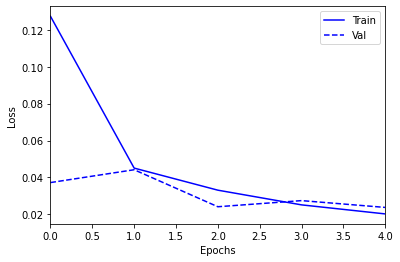

In [14]:
import matplotlib.pyplot as plt

plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.plot(history.epoch, history.history["loss"], color="blue", label='Train')
plt.plot(history.epoch, history.history['val_loss'], '--', label='Val', color="blue")

plt.legend()
plt.xlim([0, max(history.epoch)])
plt.show()

### Матрица ошибок

**Матрица ошибок** - чтобы лучше понять в каких случаях ошиблась нейронная сеть, можно построить матрицу ошибок: по оси Х будет предсказанная цифра, а по оси Y правильный вариант. В идеальном варианте все предсказания будут лежать на диагонали.

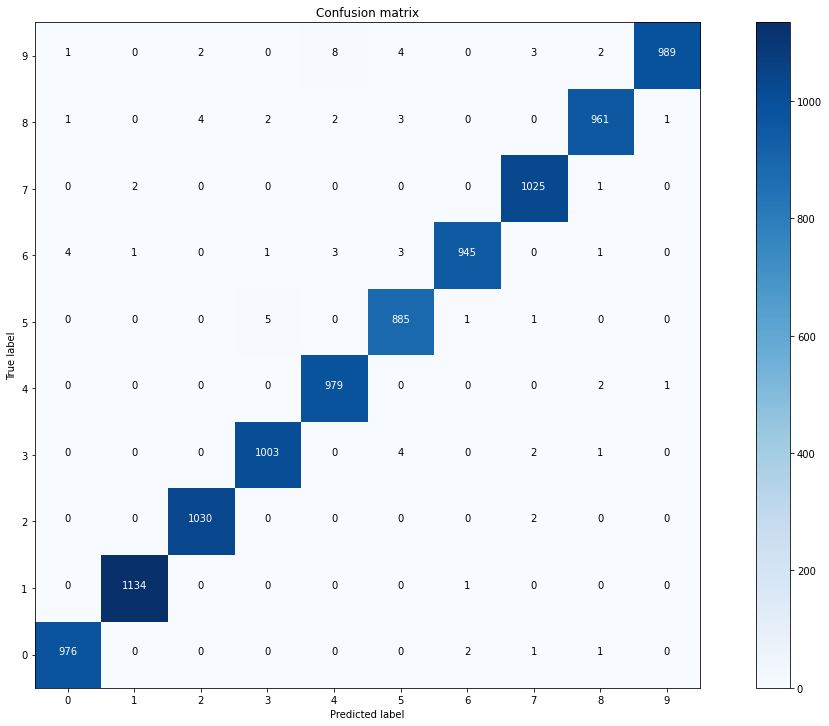

In [15]:
%matplotlib inline

def plot_confusion_matrix(cm ,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be appplied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.xlim((-0.5, len(classes)-0.5))
    plt.ylim((-0.5, len(classes)-0.5))
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
X_val = x_test
Y_true = y_test
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10))

### Ещё пример отображения цифр

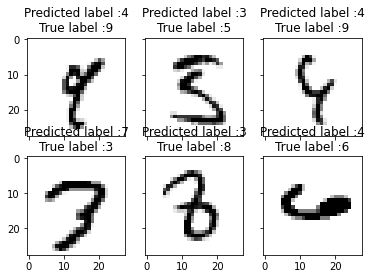

In [16]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap="gray_r")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## ✅ Задание 1: 
Отобразить с помощью matlpotlib на одном графике историю accuracy для двух моделей с 10-ю эпохами:
 + модель с прошлого занятия
 + свёрточная модель с этого занятия

In [21]:
model_old = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_old.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model_cnn = Sequential([
  Conv2D(32,kernel_size=(3,3), input_shape=input_shape, activation ='relu', padding='same'),
	Conv2D(32,kernel_size=(3,3), activation ='relu', padding='same'),
	MaxPool2D(pool_size=(2, 2)),
	

	Conv2D(64,kernel_size=(3,3), activation ='relu', padding = 'same'),
	Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'),
  MaxPool2D(pool_size=(2, 2)),
    
	Flatten(),
  Dense(128, activation=tf.nn.relu),
  Dropout(0.25),
  Dense(10, activation=tf.nn.softmax)])

model_cnn.compile(optimizer="adam",
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

history_1 = model_old.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
history_2 = model_cnn.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# plt.plot(

# plt.show(

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9181 - accuracy: 0.7574 - val_loss: 0.4275 - val_accuracy: 0.8936
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4177 - accuracy: 0.8853 - val_loss: 0.3279 - val_accuracy: 0.9121
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3547 - accuracy: 0.8992 - val_loss: 0.2937 - val_accuracy: 0.9189
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3219 - accuracy: 0.9087 - val_loss: 0.2714 - val_accuracy: 0.9254
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3028 - accuracy: 0.9132 - val_loss: 0.2537 - val_accuracy: 0.9283
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2847 - accuracy: 0.9183 - val_loss: 0.2402 - val_accuracy: 0.9305
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2735 - accuracy: 0.9216 - val_loss: 0.2299 - val_accuracy:

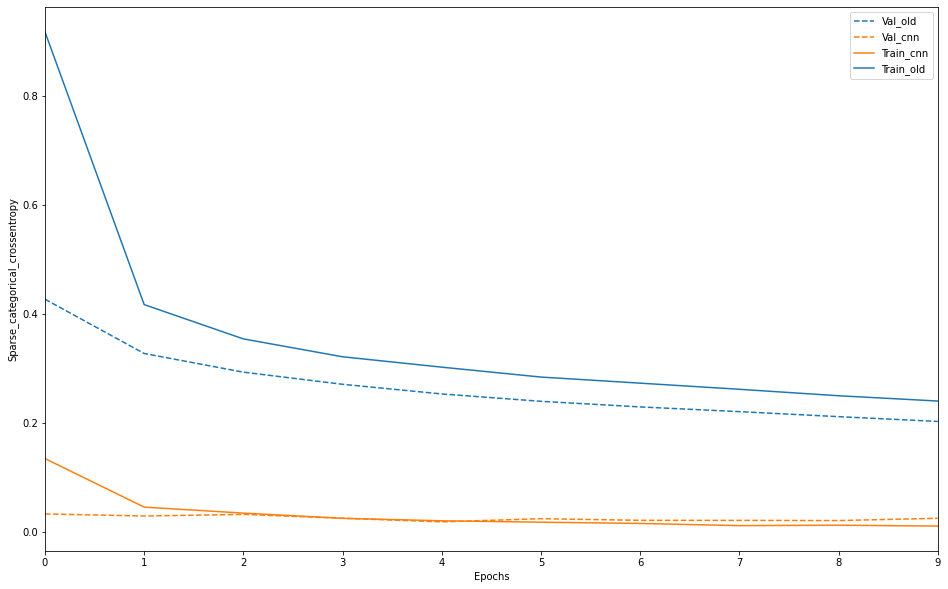

In [30]:
plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("Sparse_categorical_crossentropy")
val_old = plt.plot(history_1.epoch, history_1.history['val_'+'loss'],
                   '--', label='Val_old')
val_cnn = plt.plot(history_2.epoch, history_2.history['val_'+'loss'],
                   '--', label='Val_cnn')
train_cnn = plt.plot(history_2.epoch, history_2.history["loss"], color=val_cnn[0].get_color(),
             label='Train_cnn')
plt.plot(history_1.epoch, history_1.history["loss"], color=val_old[0].get_color(),
             label='Train_old')
plt.legend()
plt.xlim([0,max(history_1.epoch + history_2.epoch)])
plt.show()

### ✅ Задание 2:

Вывести слои активации модели нейронной сети, то есть изображения, прошедшие через слои нейронной сети.

+ Найти в документации [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) как достать слои активации
+ Найти в документации или в примерах [Matplotlib](https://matplotlib.org/3.1.1/gallery/index.html) как вывести несколько изображений близко к друг-другу
+ Поскольку изображения будут не в диапазоне (0, 255), то найти как вывести тепловую карту
+ Вывести несколько слоёв активации для свёрточной модели

In [ ]:
# layer_outputs = [layer.output for layer in model.layers[:-1]]
# activation_model = tf.keras.Model(inputs = model.input, outputs = layer_outputs)

# test_im = x_train[2979] # Random image
# activations = activation_model.predict(test_im.reshape(1,28,28,1))

# layer_activation = activations[0]

# DRAW PLOTS